### Importing required libraies

In [1]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

#### Function to download data from different sources

In [2]:

def download_data(source, series_id, start_date='2000-01-01', end_date='2024-01-01'):
    if source == 'fred':
        url = f'https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}&cosd={start_date}&coed={end_date}'
        df = pd.read_csv(url, parse_dates=['DATE'])
        df.set_index('DATE', inplace=True)
    elif source == 'yahoo':
        df = yf.download(series_id, start=start_date, end=end_date)['Adj Close']
    else:
        raise ValueError("Invalid data source. Choose 'fred' or 'yahoo'.")
    return df

#### Download the data

In [3]:
# Download data for the main feature (Home Price Index from FRED)
home_price_index = download_data('fred', 'CSUSHPISA')

# Download additional features
interest_rate = download_data('fred', 'FEDFUNDS')
consumer_price_index = download_data('fred', 'CPIAUCSL')
unemployment_rate = download_data('fred', 'UNRATE')
gdp = download_data('fred', 'GDP')
median_income = download_data('fred', 'MEHOINUSA646N')
housing_starts = download_data('fred', 'HOUST')
sp500 = download_data('yahoo', '^GSPC')
dow_jones = download_data('yahoo', '^DJI')
mortgage_rates = download_data('fred', 'MORTGAGE30US')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Create the dataframe

In [4]:
# Combine all datasets
data = pd.concat([home_price_index, interest_rate, consumer_price_index, unemployment_rate, gdp, median_income, housing_starts,
                  sp500, dow_jones, mortgage_rates], axis=1)

# Rename columns
data.columns = ['HomePriceIndex', 'InterestRate', 'ConsumerPriceIndex', 'UnemploymentRate', 'GDP', 'MedianHouseholdIncome', 'HousingStarts',
                'S&P500', 'DowJones', 'MortgageRate']

#### Data cleaning

In [5]:
# Handle missing values if necessary
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

#### Feature Engineering

In [6]:
# Lagged Features
for lag in range(1, 4):
    data[f'HomePriceIndex_Lag{lag}'] = data['HomePriceIndex'].shift(lag)
    data[f'S&P500_Lag{lag}'] = data['S&P500'].shift(lag)
    data[f'DowJones_Lag{lag}'] = data['DowJones'].shift(lag)

# Rolling Statistics
data['HomePriceIndex_RollMean3'] = data['HomePriceIndex'].rolling(window=3).mean()
data['HomePriceIndex_RollStd3'] = data['HomePriceIndex'].rolling(window=3).std()

# Interaction Features
data['InterestRate_UnemploymentRate'] = data['InterestRate'] * data['UnemploymentRate']
data['CPI_MedianIncome'] = data['ConsumerPriceIndex'] * data['MedianHouseholdIncome']
data['GDP_HousingStarts'] = data['GDP'] * data['HousingStarts']
data['SP500_MortgageRate'] = data['S&P500'] * data['MortgageRate']
data['DowJones_MortgageRate'] = data['DowJones'] * data['MortgageRate']

In [7]:
# Drop rows with NaN values generated from lagging and rolling operations
data.dropna(inplace=True)

#### Check for correlations

In [8]:
correlation_matrix = data.corr()
sorted_correlation = correlation_matrix['HomePriceIndex'].sort_values(ascending=False)
print(sorted_correlation)

HomePriceIndex                   1.000000
HomePriceIndex_RollMean3         0.999989
HomePriceIndex_Lag1              0.999980
HomePriceIndex_Lag2              0.999962
HomePriceIndex_Lag3              0.999943
CPI_MedianIncome                 0.930735
GDP                              0.919568
MedianHouseholdIncome            0.918200
S&P500_Lag3                      0.916537
S&P500_Lag2                      0.916493
S&P500_Lag1                      0.916439
S&P500                           0.916382
DowJones_Lag3                    0.912024
DowJones_Lag2                    0.911979
DowJones_Lag1                    0.911927
DowJones                         0.911875
ConsumerPriceIndex               0.891481
GDP_HousingStarts                0.840021
DowJones_MortgageRate            0.817789
SP500_MortgageRate               0.811193
HousingStarts                    0.146869
HomePriceIndex_RollStd3          0.097520
InterestRate                     0.045807
InterestRate_UnemploymentRate   -0

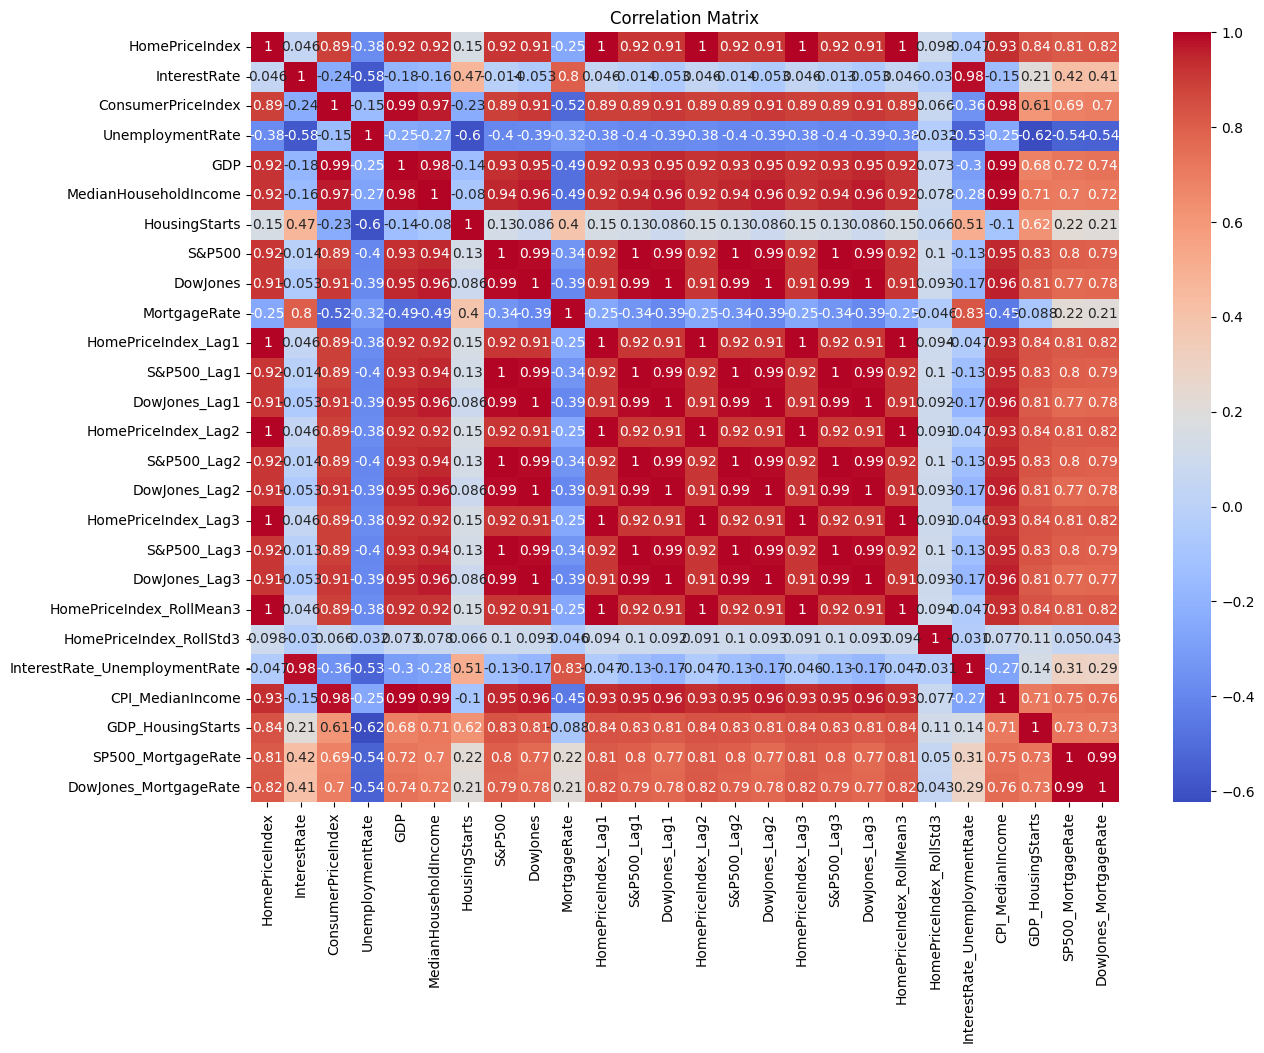

In [9]:
# Drop less relevant features based on correlation
features_to_drop = ['InterestRate', 'HousingStarts', 'HomePriceIndex_RollStd3', 'InterestRate_UnemploymentRate', 'MortgageRate', 'UnemploymentRate']
data.drop(columns=features_to_drop, inplace=True)

# Visualize correlations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Preparing data for model building

In [10]:
# Define the target variable and features
X = data.drop(columns=['HomePriceIndex'])
y = data['HomePriceIndex']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### linear regression model

In [12]:
# Initialize and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the linear regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - Mean Squared Error: {mse_lr}')
print(f'Linear Regression - R-squared: {r2_lr}')

Linear Regression - Mean Squared Error: 4.281305904815475e-26
Linear Regression - R-squared: 1.0


#### Ridge Regression

In [13]:
ridge_model = Ridge()
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5)
ridge_grid.fit(X_train_scaled, y_train)
best_ridge_model = ridge_grid.best_estimator_

# Make predictions with Ridge
y_pred_ridge = best_ridge_model.predict(X_test_scaled)

# Evaluate the Ridge regression model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge Regression - Mean Squared Error: {mse_ridge}')
print(f'Ridge Regression - R-squared: {r2_ridge}')

Ridge Regression - Mean Squared Error: 0.048162546621689374
Ridge Regression - R-squared: 0.9999820028331492


#### Lasso Regression

In [14]:
lasso_model = Lasso()
lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5)
lasso_grid.fit(X_train_scaled, y_train)
best_lasso_model = lasso_grid.best_estimator_

# Make predictions with Lasso
y_pred_lasso = best_lasso_model.predict(X_test_scaled)

# Evaluate the Lasso regression model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Lasso Regression - Mean Squared Error: {mse_lasso}')
print(f'Lasso Regression - R-squared: {r2_lasso}')

Lasso Regression - Mean Squared Error: 0.08530048294842596
Lasso Regression - R-squared: 0.9999681252937861


#### Random Forest model

In [15]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate Random Forest model
print("Random Forest R-squared:", r2_score(y_test, rf_pred))
print("Random Forest RMSE:", mean_squared_error(y_test, rf_pred, squared=False))

Random Forest R-squared: 0.9999867015306576
Random Forest RMSE: 0.1886485528104131


#### Coefficients for Linear Regression

In [16]:
lr_coef = pd.Series(lr_model.coef_, index=X.columns)
print(lr_coef)

ConsumerPriceIndex         -6.970781e-15
GDP                         1.278977e-13
MedianHouseholdIncome       5.195297e-14
S&P500                     -3.025170e-13
DowJones                    2.912649e-13
HomePriceIndex_Lag1        -5.102018e+01
S&P500_Lag1                 2.872493e-13
DowJones_Lag1              -2.339901e-13
HomePriceIndex_Lag2        -5.099525e+01
S&P500_Lag2                -2.625098e-13
DowJones_Lag2               3.034981e-13
HomePriceIndex_Lag3         4.697216e-14
S&P500_Lag3                 2.007406e-13
DowJones_Lag3              -1.755160e-13
HomePriceIndex_RollMean3    1.530586e+02
CPI_MedianIncome           -1.443589e-13
GDP_HousingStarts          -6.442512e-15
SP500_MortgageRate          2.775558e-14
DowJones_MortgageRate       1.776357e-14
dtype: float64


#### Feature importances for Random Forest

In [17]:
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(rf_importances)

ConsumerPriceIndex          0.073976
GDP                         0.008482
MedianHouseholdIncome       0.000098
S&P500                      0.000285
DowJones                    0.000146
HomePriceIndex_Lag1         0.096285
S&P500_Lag1                 0.000266
DowJones_Lag1               0.000040
HomePriceIndex_Lag2         0.052381
S&P500_Lag2                 0.000040
DowJones_Lag2               0.000035
HomePriceIndex_Lag3         0.031773
S&P500_Lag3                 0.000080
DowJones_Lag3               0.000223
HomePriceIndex_RollMean3    0.723189
CPI_MedianIncome            0.011647
GDP_HousingStarts           0.000072
SP500_MortgageRate          0.000865
DowJones_MortgageRate       0.000120
dtype: float64


In [18]:
import joblib
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(ridge_model, 'ridge_regression_model.pkl')
joblib.dump(lasso_model, 'lasso_regression_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

#### Visualize feature importances

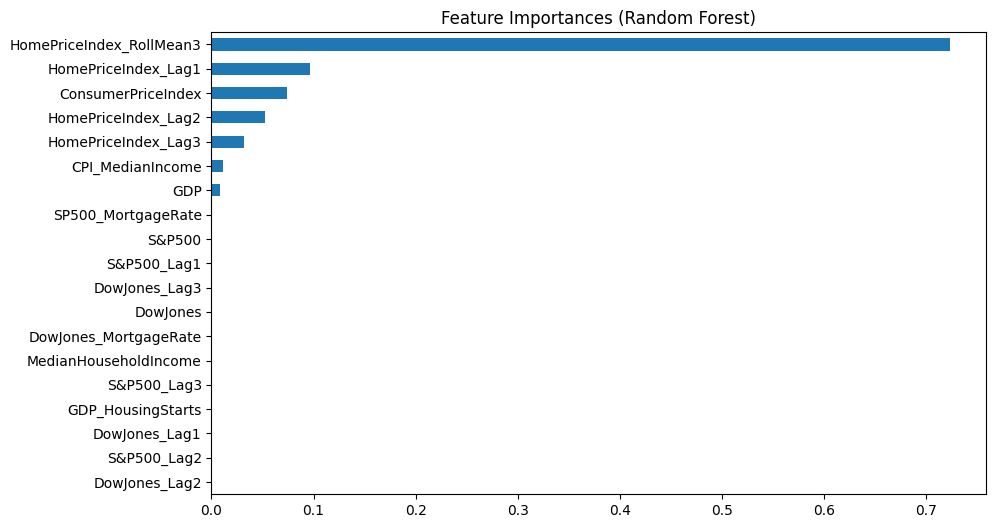

In [19]:
plt.figure(figsize=(10, 6))
rf_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances (Random Forest)')
plt.show()

#### Residual analysis for Linear Regression

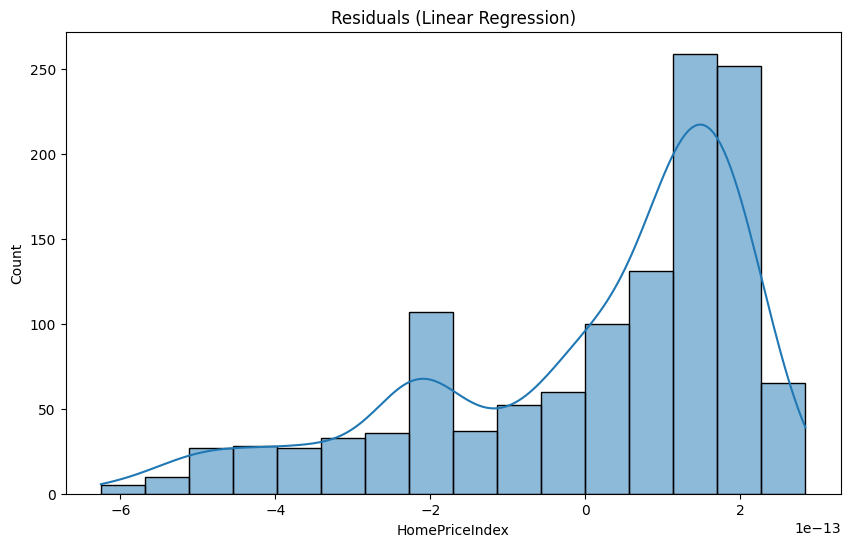

In [20]:
residuals_lr = y_test - y_pred_lr
plt.figure(figsize=(10, 6))
sns.histplot(residuals_lr, kde=True)
plt.title('Residuals (Linear Regression)')
plt.show()

#### Save final dataset and model evaluations

In [21]:
data.to_csv('final_dataset.csv')

In [22]:
model_evaluations = {
    'Linear Regression': {'MSE': mse_lr, 'R2': r2_lr},
    'Ridge Regression': {'MSE': mse_ridge, 'R2': r2_ridge},
    'Lasso Regression': {'MSE': mse_lasso, 'R2': r2_lasso},
    'Random Forest': {'R2': r2_score(y_test, rf_pred), 'RMSE': mean_squared_error(y_test, rf_pred, squared=False)}}

In [23]:
print("Model Evaluation Results:")
for model, metrics in model_evaluations.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

Model Evaluation Results:

Linear Regression:
  MSE: 4.281305904815475e-26
  R2: 1.0

Ridge Regression:
  MSE: 0.048162546621689374
  R2: 0.9999820028331492

Lasso Regression:
  MSE: 0.08530048294842596
  R2: 0.9999681252937861

Random Forest:
  R2: 0.9999867015306576
  RMSE: 0.1886485528104131


In [24]:
import json

with open('model_evaluation_results.json', 'w') as f:
    json.dump(model_evaluations, f, indent=4)

#### Plotting Actual vs. Predicted values for each model

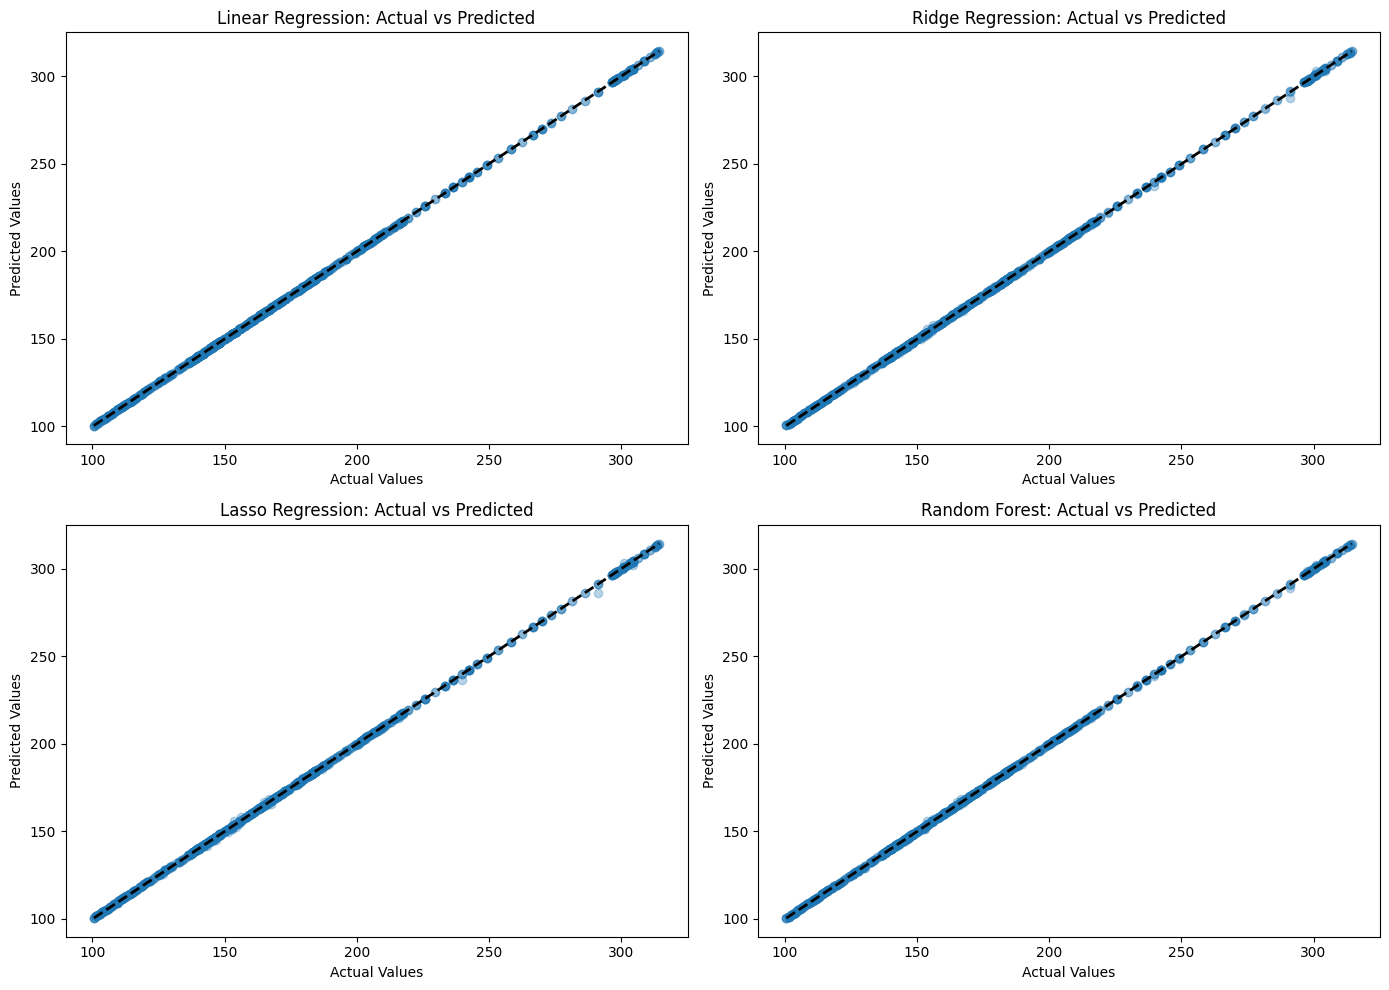

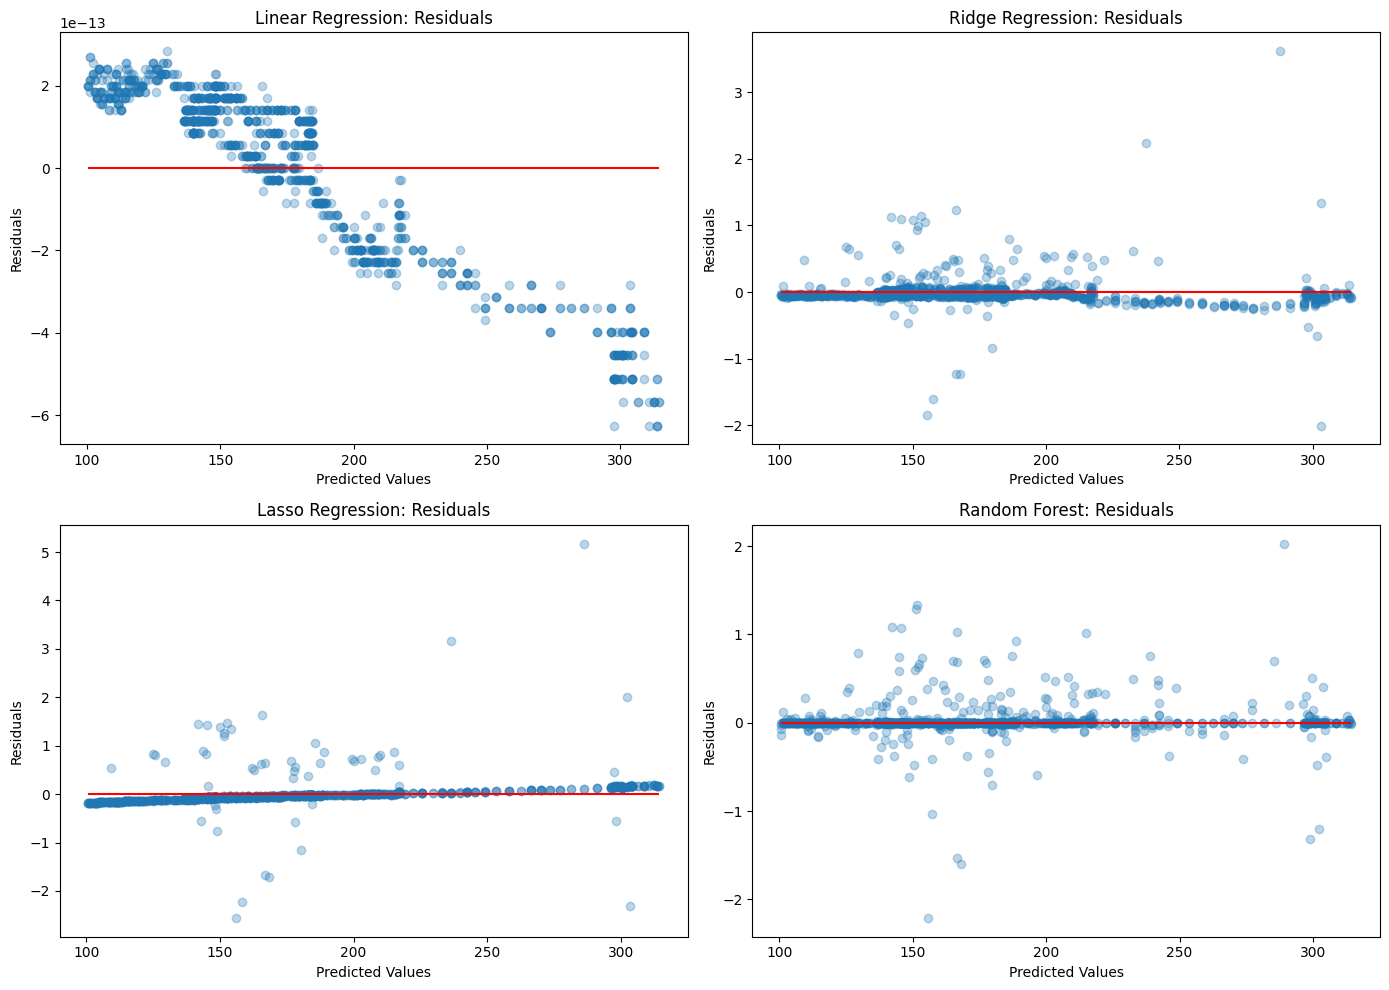

In [25]:
plt.figure(figsize=(14, 10))

# Linear Regression
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Ridge Regression
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_ridge, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Ridge Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Lasso Regression
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_lasso, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Lasso Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Random Forest
plt.subplot(2, 2, 4)
plt.scatter(y_test, rf_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

# Residual plots
plt.figure(figsize=(14, 10))

# Linear Regression
plt.subplot(2, 2, 1)
plt.scatter(y_pred_lr, y_test - y_pred_lr, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_lr.min(), xmax=y_pred_lr.max(), color='red')
plt.title('Linear Regression: Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Ridge Regression
plt.subplot(2, 2, 2)
plt.scatter(y_pred_ridge, y_test - y_pred_ridge, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_ridge.min(), xmax=y_pred_ridge.max(), color='red')
plt.title('Ridge Regression: Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Lasso Regression
plt.subplot(2, 2, 3)
plt.scatter(y_pred_lasso, y_test - y_pred_lasso, alpha=0.3)
plt.hlines(y=0, xmin=y_pred_lasso.min(), xmax=y_pred_lasso.max(), color='red')
plt.title('Lasso Regression: Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Random Forest
plt.subplot(2, 2, 4)
plt.scatter(rf_pred, y_test - rf_pred, alpha=0.3)
plt.hlines(y=0, xmin=rf_pred.min(), xmax=rf_pred.max(), color='red')
plt.title('Random Forest: Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()